<a href="https://colab.research.google.com/github/SarkarPriyanshu/LifeExpectancy/blob/main/Life_Expectancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kumarajarshi/life-expectancy-who

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who
License(s): other
life-expectancy-who.zip: Skipping, found more recently modified local copy (use --force to force download)



![Waterfall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Life_expectancy_UN_map_gradient_2023_at_age_15.png/1280px-Life_expectancy_UN_map_gradient_2023_at_age_15.png)

### Data Loading

In [303]:
import zipfile

zip_ref = zipfile.ZipFile("/content/life-expectancy-who.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [304]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [305]:
df = pd.read_csv('/content/Life Expectancy Data.csv')

### Basic Analysis

In [306]:
df.shape

(2938, 22)

In [307]:
df.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1646,Malta,2003,Developed,78.5,71.0,0,6.70,1678.392773,89.0,4,63.9,0,94.0,8.60,94.0,0.1,13689.989990,398582.0,0.7,0.7,0.790,13.8
1198,India,2003,Developing,63.7,216.0,1700,1.19,19.480868,NaN,47147,12.6,2200,57.0,4.30,61.0,0.3,541.135228,11827848.0,27.3,28.3,0.505,8.6
2807,United States of America,2002,Developed,77.0,115.0,28,8.33,0.000000,88.0,41,61.7,33,9.0,14.55,94.0,0.1,NaN,NaN,0.8,0.6,NaN,NaN
2748,United Arab Emirates,2013,Developing,76.7,78.0,1,1.82,377.200913,98.0,0,6.5,1,98.0,3.49,98.0,0.1,4335.642680,NaN,5.2,5.0,0.829,13.3
1292,Italy,2005,Developed,88.0,66.0,2,8.65,4506.255963,96.0,135,58.2,2,97.0,8.71,95.0,0.1,31959.262150,57969484.0,0.5,0.5,0.851,15.8


In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [309]:
describe = df.select_dtypes(exclude='object').describe().T
describe['skew'] = df.select_dtypes(exclude='object').skew()
describe['kurtosis'] = df.select_dtypes(exclude='object').kurtosis()
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03,-0.006409,-1.213722
Life expectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01,-0.638605,-0.234477
Adult Mortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02,1.174369,1.748860
infant deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03,9.786963,116.042756
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01,0.589563,-0.802909
percentage expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04,4.652051,26.573387
Hepatitis B,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01,-1.930845,2.770259
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05,9.441332,114.859903
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01,-0.219312,-1.291095
under-five deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03,9.495065,109.752795


**Observations**
- Features have null/missing data
- Highly skewed features like.
- Feature contain extreme values due to high kurtosis


### Null value analysis & Imputaions

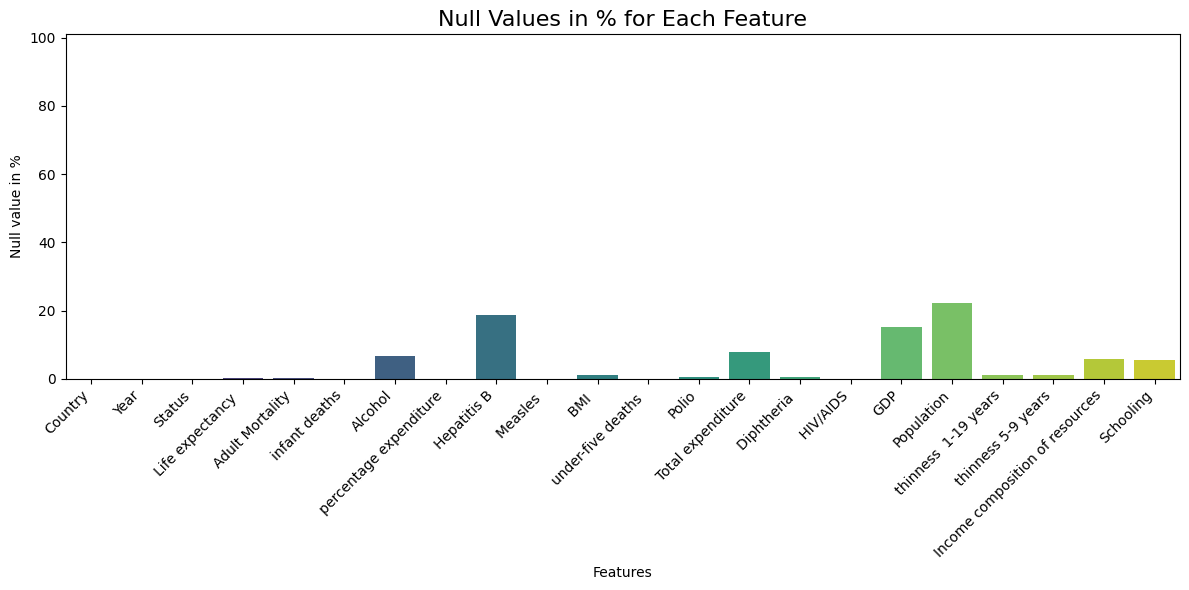

In [310]:
# Calculate the percentage of null values for each feature
null_values_count = round(df.isna().sum() / df.shape[0] * 100, 2).reset_index().rename(columns={'index': 'Features', 0: 'Null value in %'})

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Features', y='Null value in %', data=null_values_count, palette='viridis')

# Set the title and adjust layout
ax.set_title('Null Values in % for Each Feature', fontsize=16)
ax.set_ylim(0, 101)  # Set the y-axis range from 0 to 101

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

**We drop the null values of Life Expectancy feature as its our target column.**

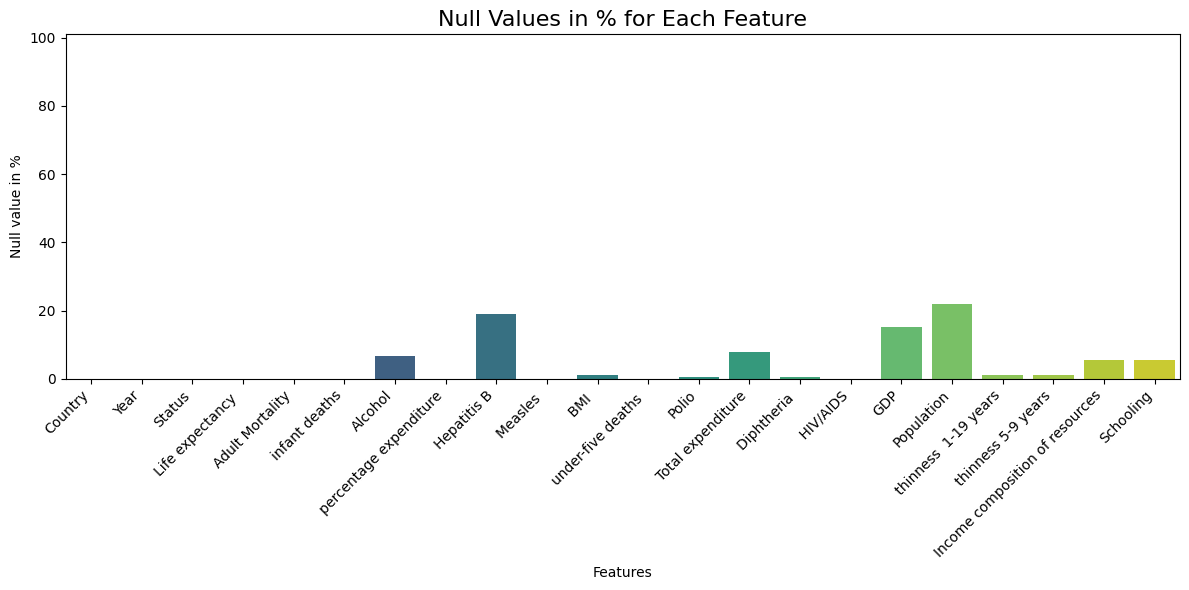

In [311]:
df = df.dropna(subset=['Life expectancy '])
# Calculate the percentage of null values for each feature
null_values_count = round(df.isna().sum() / df.shape[0] * 100, 2).reset_index().rename(columns={'index': 'Features', 0: 'Null value in %'})

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Features', y='Null value in %', data=null_values_count, palette='viridis')

# Set the title and adjust layout
ax.set_title('Null Values in % for Each Feature', fontsize=16)
ax.set_ylim(0, 101)  # Set the y-axis range from 0 to 101

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


**Handling missing data of columns that have less than 5% missing data out of total data**
- ' BMI ',
- 'Polio',
- 'Diphtheria ',
- ' thinness  1-19 years',
-  ' thinness 5-9 years'

In [312]:
Missing_data_features_less_than5 = [' BMI ','Polio','Diphtheria ',' thinness  1-19 years', ' thinness 5-9 years']

In [313]:
# Checking the mean different between two group (Develop vs Developing countries).

df.groupby('Status',as_index=False)\
.agg({' BMI ': 'mean','Polio':'mean','Diphtheria ':'mean',' thinness  1-19 years':'mean', ' thinness 5-9 years':'mean'})

,Status,BMI,Polio,Diphtheria,thinness 1-19 years,thinness 5-9 years
0,Developed,51.803906,93.736328,93.476562,1.320703,1.29668
1,Developing,35.321351,80.158531,79.938673,5.608725,5.65130


In [314]:
df.groupby('Status',as_index=False).agg({'Country': 'count'})

,Status,Country
0,Developed,512
1,Developing,2416


In [315]:
# Checking the missing data in terms of countries status

display(df.loc[(df['Status']=='Developing')][['Country',' BMI ','Polio','Diphtheria ',' thinness  1-19 years', ' thinness 5-9 years']]\
        .isna()\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'(Developing Countries) Feature',0:'Null value counts'}))
display(df.loc[(df['Status']=='Developed')][['Country',' BMI ','Polio','Diphtheria ',' thinness  1-19 years', ' thinness 5-9 years']]\
        .isna()\
        .sum()\
        .reset_index()\
        .rename(columns={'index':'(Developed Countries) Feature',0:'Null value counts'}))

,(Developing Countries) Feature,Null value counts
0,Country,0
1,BMI,32
2,Polio,19
3,Diphtheria,19
4,thinness 1-19 years,32
5,thinness 5-9 years,32


,(Developed Countries) Feature,Null value counts
0,Country,0
1,BMI,0
2,Polio,0
3,Diphtheria,0
4,thinness 1-19 years,0
5,thinness 5-9 years,0


**Note**
- What we are going to do here is impute the median value as the distribution is skewed and check if it affect the overall distribution if there is no affect then we go with this imputation.


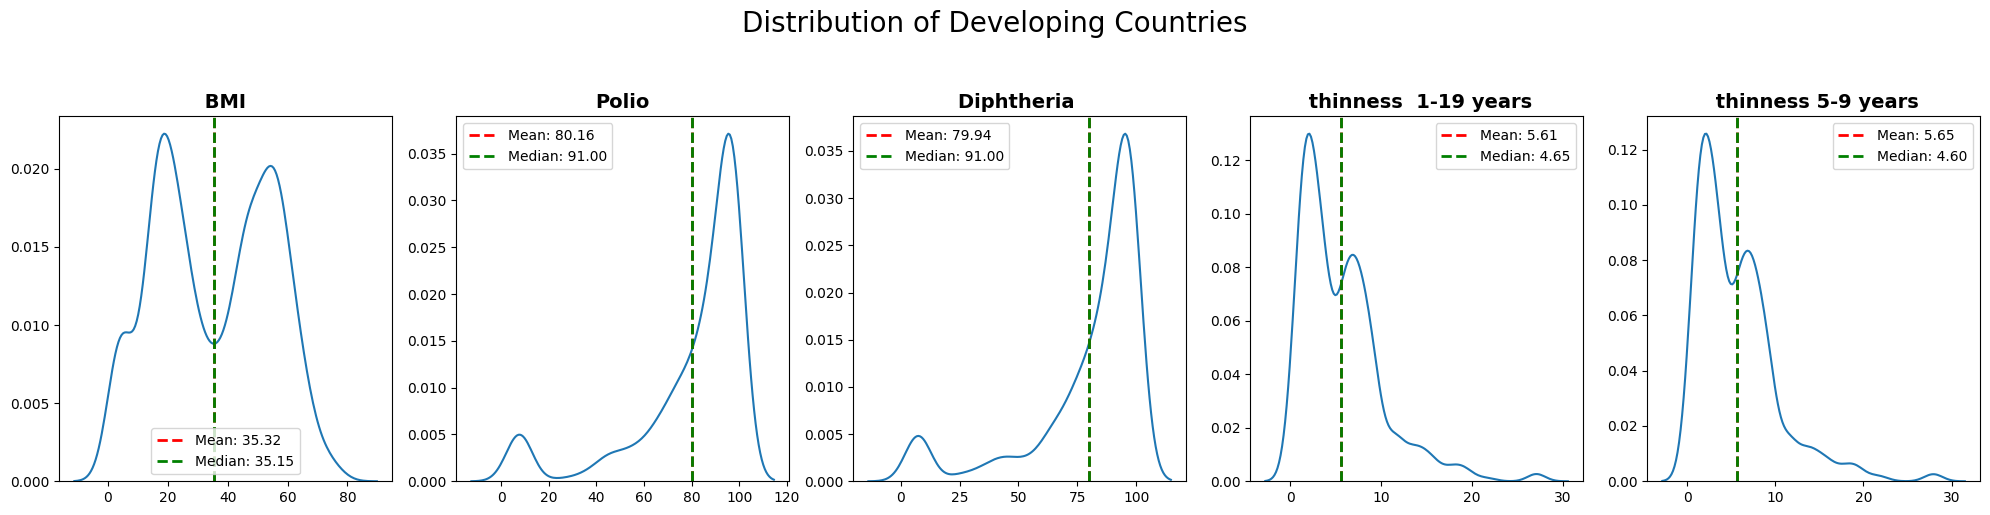

In [316]:
filtered_Data = df.loc[(df['Status']=='Developing')][Missing_data_features_less_than5]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle("Distribution of Developing Countries", fontsize=20, y=1.02)

numeric_cols = filtered_Data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(filtered_Data[col], ax=ax)
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = filtered_Data[col].mean()
  median_value = filtered_Data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


In [317]:
# Storing the median values of features

BMI_median =  round(filtered_Data[' BMI '].median(),2)
Polio_median = round(filtered_Data['Polio'].median(),2)
Diphtheria_median = round(filtered_Data['Diphtheria '].median(),2)
thinness1_19_median = round(filtered_Data[' thinness  1-19 years'].median(),2)
thinness5_9_median = round(filtered_Data[' thinness 5-9 years'].median(),2)

Missing_data_features_less_than5_values = [BMI_median,Polio_median,Diphtheria_median,thinness1_19_median,thinness5_9_median]

In [318]:
# Imputing median values

After_filtered_Data = filtered_Data.copy()
After_filtered_Data[' BMI '].fillna(BMI_median,inplace=True)
After_filtered_Data['Polio'].fillna(Polio_median,inplace=True)
After_filtered_Data['Diphtheria '].fillna(Diphtheria_median,inplace=True)
After_filtered_Data[' thinness  1-19 years'].fillna(thinness1_19_median,inplace=True)
After_filtered_Data[' thinness 5-9 years'].fillna(thinness5_9_median,inplace=True)

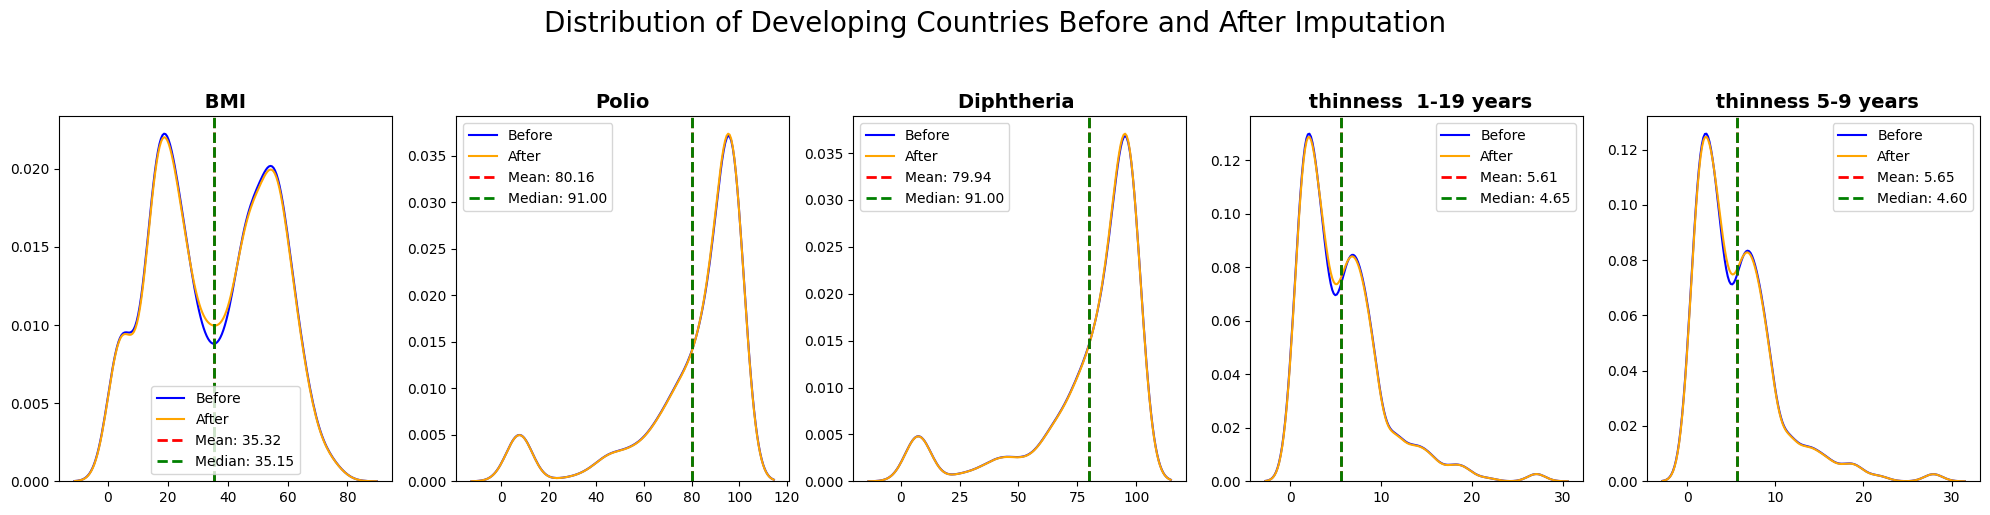

In [319]:
filtered_Data = df.loc[(df['Status']=='Developing')][Missing_data_features_less_than5]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle("Distribution of Developing Countries Before and After Imputation", fontsize=20, y=1.02)

numeric_cols = filtered_Data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(filtered_Data[col], ax=ax, label='Before', color='blue')
  sns.kdeplot(After_filtered_Data[col], ax=ax, label='After', color='orange')
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = filtered_Data[col].mean()
  median_value = filtered_Data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

del filtered_Data
del After_filtered_Data

**Observations**
- We drop the null values of `Life Expectancy` feature as its our target column.
- `Sudan` is country where `BMI` data is missing for all years from `2001 - 2015`
- `South Sudan` `Polio` and `Diphtheria` data is missing from `2001 - 2011` that indicates the data is started to recorded after `2011`

- `Countries` with `Developing` status have missing data in `BMI`, `POLIO`,`Diphtheria` columns

- Developed countries have lessor in no as compared to Developing Countries but still have high mean values than other one, that means there is a huge gap between this countries we can't impute the missing values considering whole data.

- We are going to impute the median values (Only considering the developing countries) on the basis of countries status as we can see they are skewed toward left

**Handling missing data of columns that have More than or equal to 5% missing data out of total data**

- 'Alcohol',
- 'Total expenditure',
- 'Income composition of resources',
- 'Schooling'

In [320]:
Missing_data_features_greater_than5 = ['Alcohol','Total expenditure','Income composition of resources','Schooling']

In [321]:
filtered_data = df[['Country','Status','Alcohol','Total expenditure','Income composition of resources','Schooling']]

In [322]:
# Check the % of null values in developing countries

round(filtered_data[filtered_data['Status']=='Developing']\
      .isna()\
      .sum()/filtered_data[filtered_data['Status']=='Developing']\
      .shape[0] * 100,2).reset_index()\
        .rename(columns={'index':'(Developing Countries) Feature',0:'Null value %'})

,(Developing Countries) Feature,Null value %
0,Country,0.00
1,Status,0.00
2,Alcohol,6.83
3,Total expenditure,8.03
4,Income composition of resources,4.64
5,Schooling,4.64


In [323]:
# Check the % of null values in developed countries

round(filtered_data[filtered_data['Status']=='Developed']\
      .isna().sum()/filtered_data[filtered_data['Status']=='Developed']\
      .shape[0] * 100,2).reset_index()\
      .rename(columns={'index':'(Developed Countries) Feature',0:'Null value %'})

,(Developed Countries) Feature,Null value %
0,Country,0.00
1,Status,0.00
2,Alcohol,5.47
3,Total expenditure,6.25
4,Income composition of resources,9.38
5,Schooling,9.38


**Note**

- Here we got missing data on both group Developed and Develping.
- So we have to calculate the median of both group seperately and then impute them and check there distribution.

In [324]:
filtered_data\
  .groupby('Status')\
  .agg({'Alcohol':['mean','median'],'Total expenditure':['mean','median'],'Income composition of resources':['mean','median'],'Schooling':['mean','median']})

Alcohol        Total expenditure         \
                mean median              mean median   
Status                                                 
Developed   9.826736  10.32          7.554042  7.895   
Developing  3.494220   2.58          5.579370  5.400   

           Income composition of resources         Schooling         
                                      mean median       mean median  
Status                                                               
Developed                         0.852489  0.862  15.845474   15.8  
Developing                        0.582092  0.631  11.225130   11.7

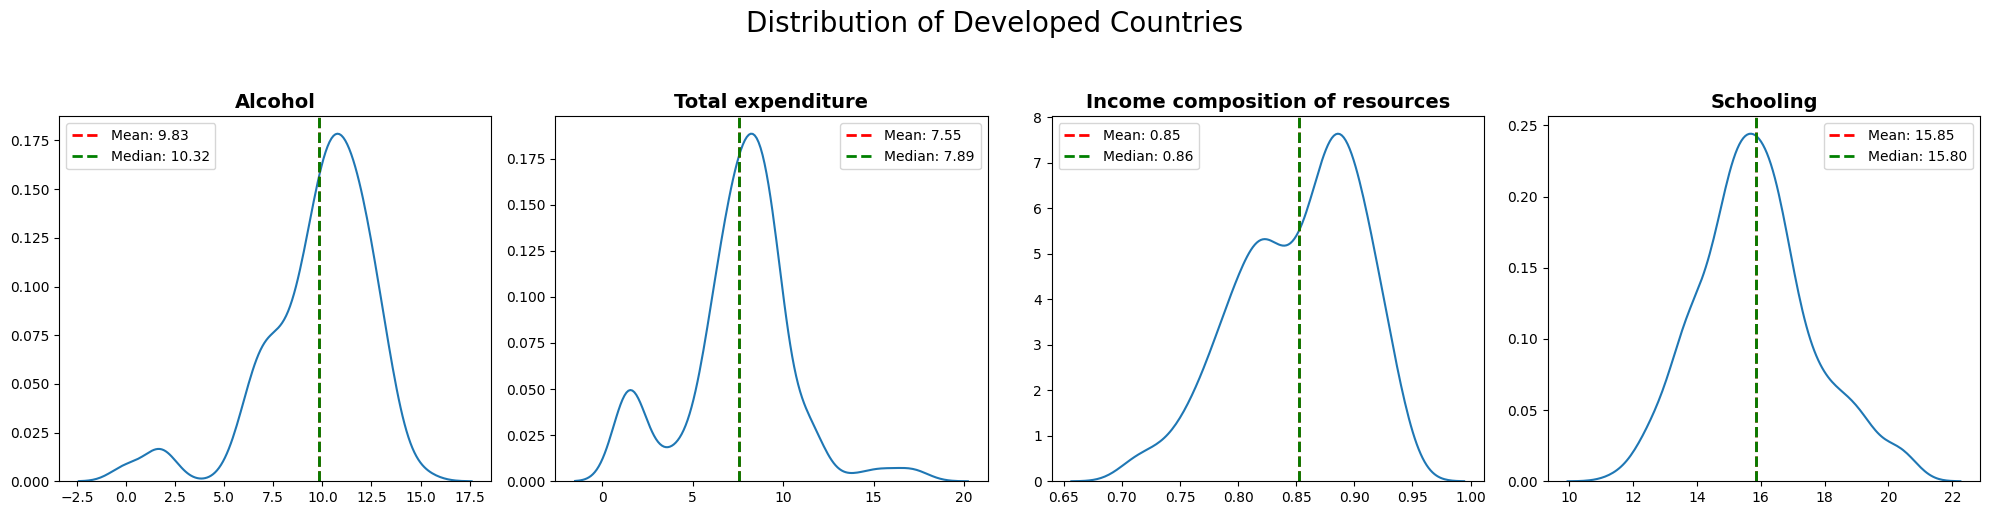

In [325]:
developed_data = filtered_data[filtered_data['Status']=='Developed'].drop(['Country','Status'],axis=1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Distribution of Developed Countries", fontsize=20, y=1.02)

numeric_cols = developed_data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(developed_data[col], ax=ax)
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = developed_data[col].mean()
  median_value = developed_data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


**Imputing missing data for developed countries**

In [326]:
Alcohol_developed_median =  round(developed_data['Alcohol'].median(),2)
Total_develped_expenditure_median = round(developed_data['Total expenditure'].median(),2)
Income_develped_composition_median = round(developed_data['Income composition of resources'].median(),2)
Schooling_develped_median = round(developed_data['Schooling'].median(),2)


Missing_data_features_greater_than5_developed_medians = [Alcohol_developed_median,
                                                         Total_develped_expenditure_median,
                                                         Income_develped_composition_median,
                                                         Schooling_develped_median]

In [327]:
After_developed_data = developed_data.copy()
After_developed_data['Alcohol'].fillna(Alcohol_developed_median,inplace=True)
After_developed_data['Total expenditure'].fillna(Total_develped_expenditure_median,inplace=True)
After_developed_data['Income composition of resources'].fillna(Income_develped_composition_median,inplace=True)
After_developed_data['Schooling'].fillna(Schooling_develped_median,inplace=True)

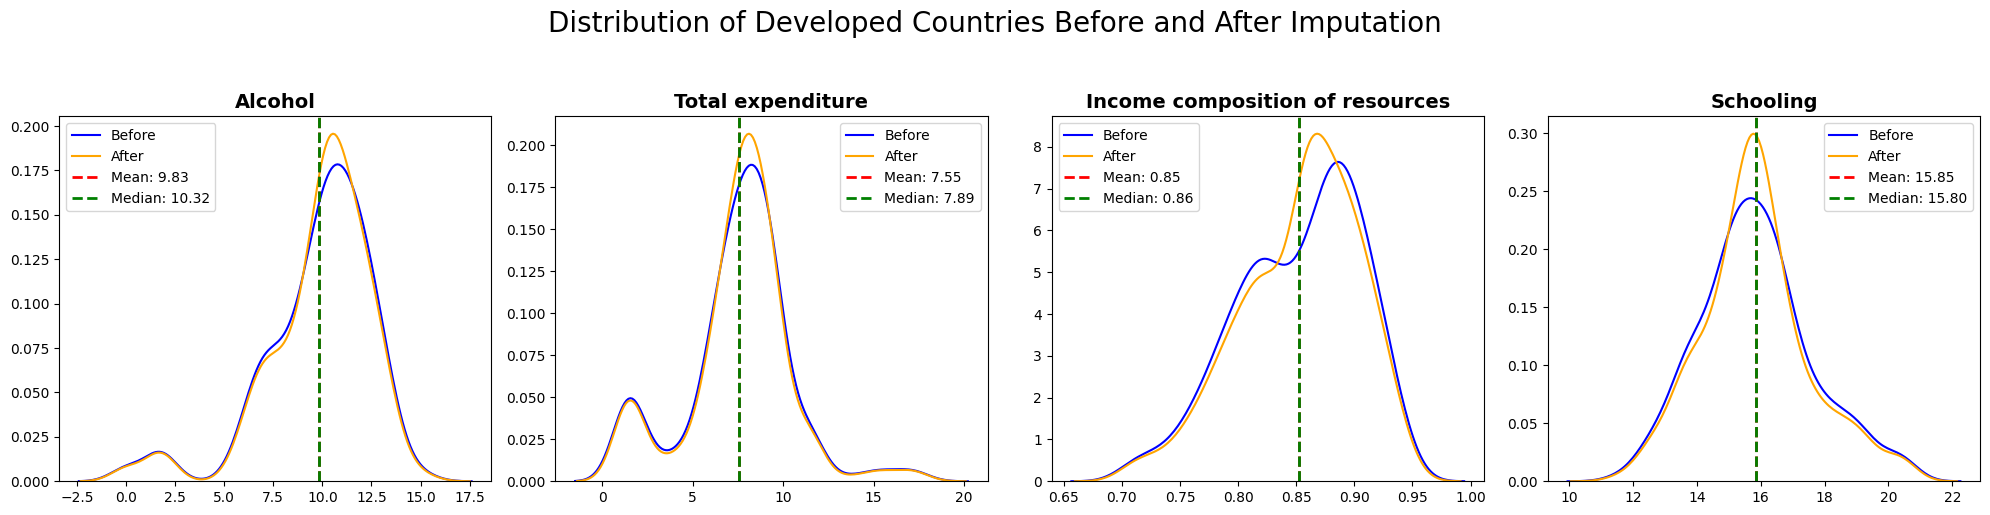

In [328]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Distribution of Developed Countries Before and After Imputation", fontsize=20, y=1.02)

numeric_cols = developed_data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(developed_data[col], ax=ax, label='Before', color='blue')
  sns.kdeplot(After_developed_data[col], ax=ax, label='After', color='orange')
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = developed_data[col].mean()
  median_value = developed_data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

del developed_data
del After_developed_data

**Imputing missing data for developing countries**

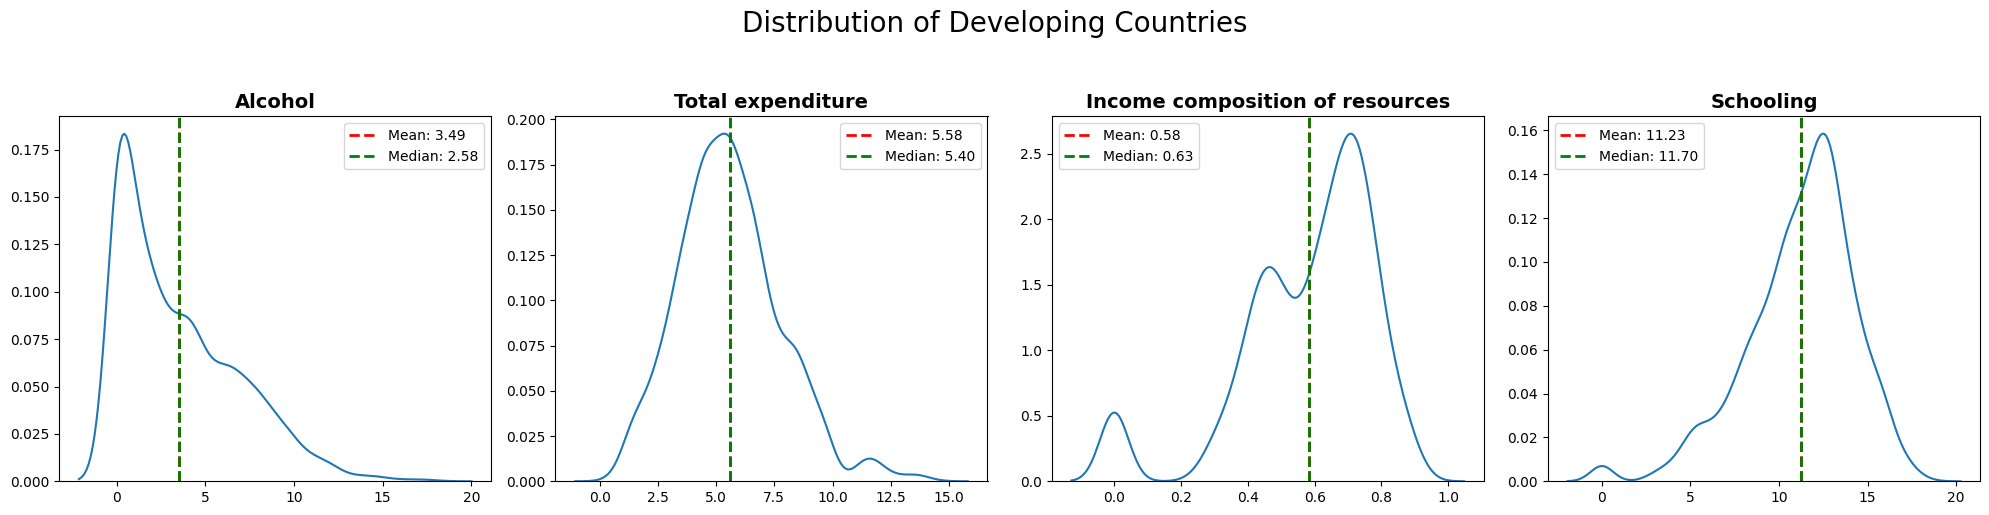

In [329]:
developing_data = filtered_data[filtered_data['Status']=='Developing'].drop(['Country','Status'],axis=1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Distribution of Developing Countries", fontsize=20, y=1.02)

numeric_cols = developing_data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(developing_data[col], ax=ax)
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = developing_data[col].mean()
  median_value = developing_data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


In [330]:
Alcohol_developing_median =  developing_data['Alcohol'].median()
Total_expenditure_developing_median = developing_data['Total expenditure'].median()
Income_composition_developing_median = developing_data['Income composition of resources'].median()
Schooling_developing_median = developing_data['Schooling'].median()

Missing_data_features_greater_than5_developing_medians = [Alcohol_developing_median,
                                                          Total_expenditure_developing_median,
                                                          Income_composition_developing_median,
                                                          Schooling_developing_median]

In [331]:
After_developing_data = developing_data.copy()
After_developing_data['Alcohol'].fillna(Alcohol_developing_median,inplace=True)
After_developing_data['Total expenditure'].fillna(Total_expenditure_developing_median,inplace=True)
After_developing_data['Income composition of resources'].fillna(Income_composition_developing_median,inplace=True)
After_developing_data['Schooling'].fillna(Schooling_developing_median,inplace=True)

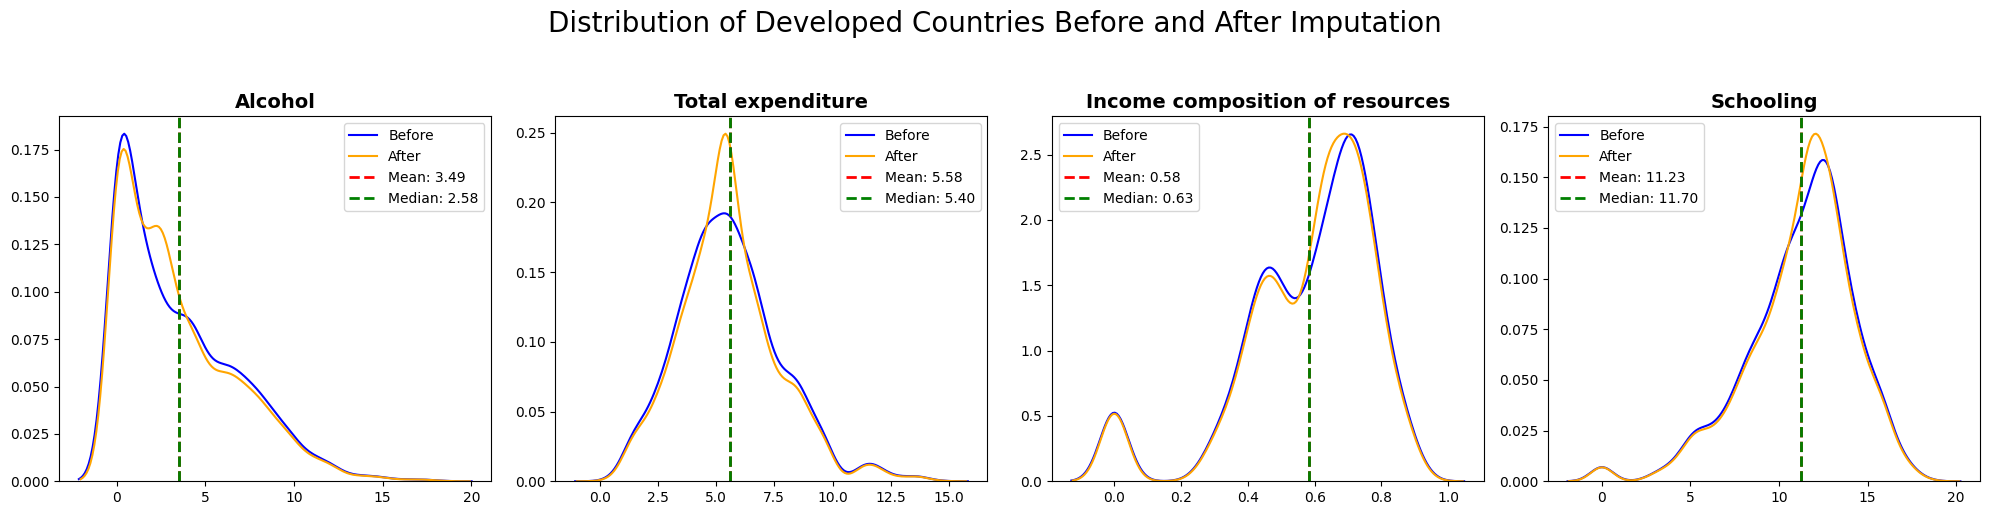

In [332]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Distribution of Developed Countries Before and After Imputation", fontsize=20, y=1.02)

numeric_cols = developing_data.columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(developing_data[col], ax=ax, label='Before', color='blue')
  sns.kdeplot(After_developing_data[col], ax=ax, label='After', color='orange')
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = developing_data[col].mean()
  median_value = developing_data[col].median()
  ax.axvline(mean_value, linestyle='dashed', color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.axvline(mean_value, linestyle='dashed', color='green', linewidth=2, label=f'Median: {median_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

del developing_data
del After_developing_data

**Observations**
- When we checked which `countries` have high number of missing data we find the same name seems like `Sudan` `Somalia` `South Sudan` have highest missing data it might be because of its `status` is `developing` and recently they got a chance to get data from this countries.

- This missing data is due to late data reporting.

- We segregate the data in terms of Countries `Status` and impute the median on both groups

- `Variance` of data remains same only change in `Central tendency` which is also acceptable

**Missing Data Imputation**

In [333]:
imp_df = df.copy()

In [334]:
values = dict(zip(Missing_data_features_less_than5,Missing_data_features_less_than5_values))
imp_df[Missing_data_features_less_than5] = imp_df[Missing_data_features_less_than5].fillna(value=values)

In [335]:
values = dict(zip(Missing_data_features_greater_than5, Missing_data_features_greater_than5_developed_medians))

for feature in Missing_data_features_greater_than5:
    imp_df.loc[imp_df['Status'] == 'Developed', feature] = imp_df.loc[imp_df['Status'] == 'Developed', feature].fillna(value=values[feature])

In [336]:
values = dict(zip(Missing_data_features_greater_than5,Missing_data_features_greater_than5_developing_medians))

for feature in Missing_data_features_greater_than5:
  imp_df.loc[imp_df['Status'] == 'Developing', feature] = imp_df.loc[imp_df['Status'] == 'Developing', feature].fillna(value=values[feature])

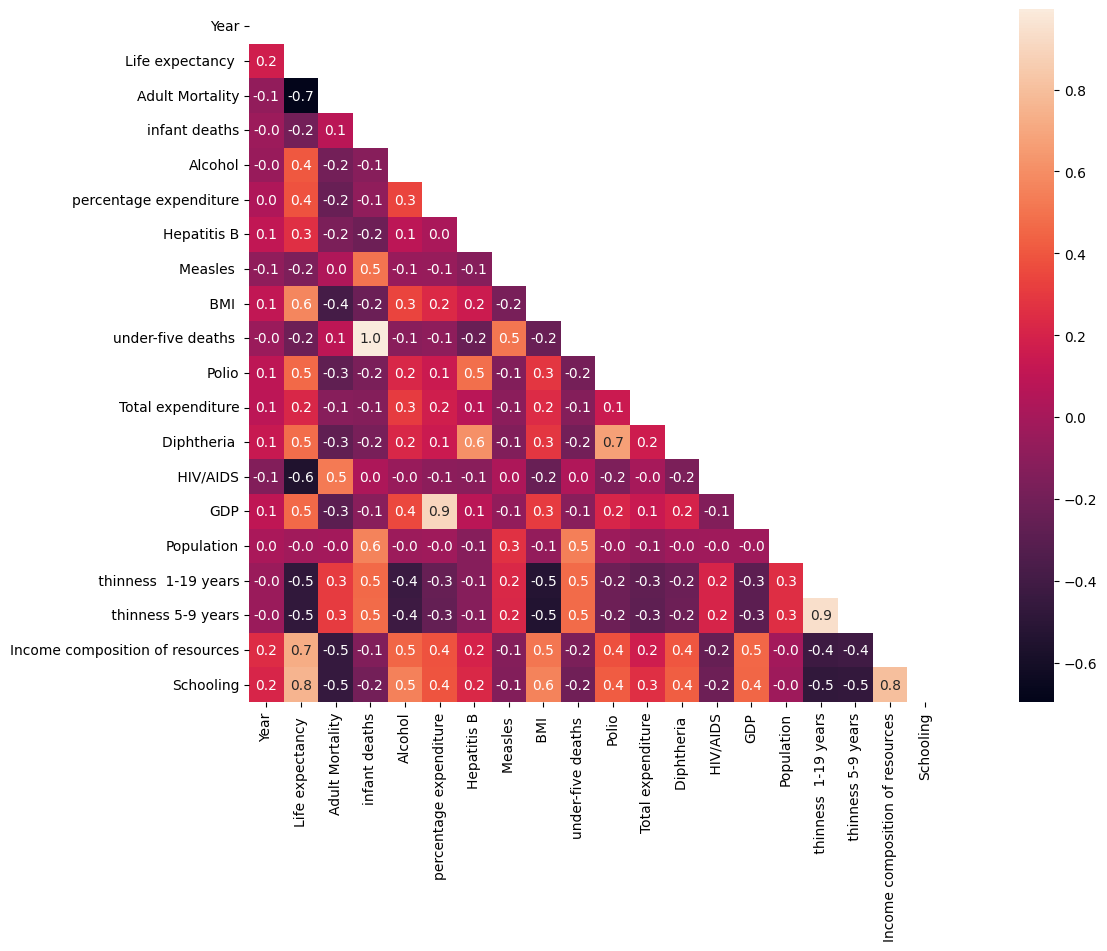

In [337]:
# Creating a Original data correlation heatmap
plt.figure(figsize=(20,9))
correlation = df.select_dtypes(exclude='object').corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt = '.1f', mask=mask, square=True)
plt.show()

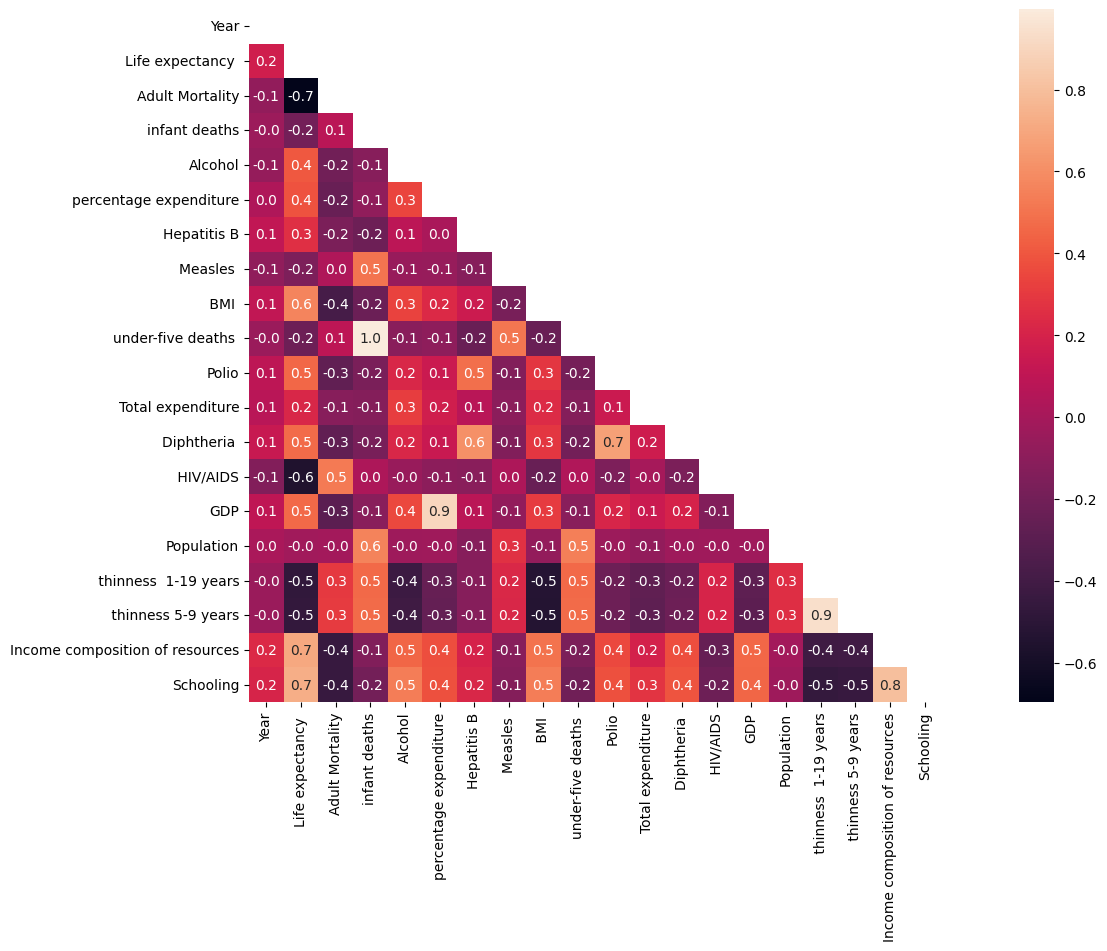

In [338]:
# Creating a After Imputation data correlation heatmap
plt.figure(figsize=(20,9))
correlation = imp_df.select_dtypes(exclude='object').corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt = '.1f', mask=mask, square=True)
plt.show()

**Observations**
- We are going to drop columns `GDP` ,`Population` and `Hepetite B` As they have null value around `15- 20%`.

- We can impute them using various techneques like KNN Imputation, etc but we are not doing it here we directly dropping this columns.

In [339]:
columns_to_drop = ['GDP','Population','Hepatitis B','Country']

imp_df.drop(columns=columns_to_drop,axis=1,inplace=True)

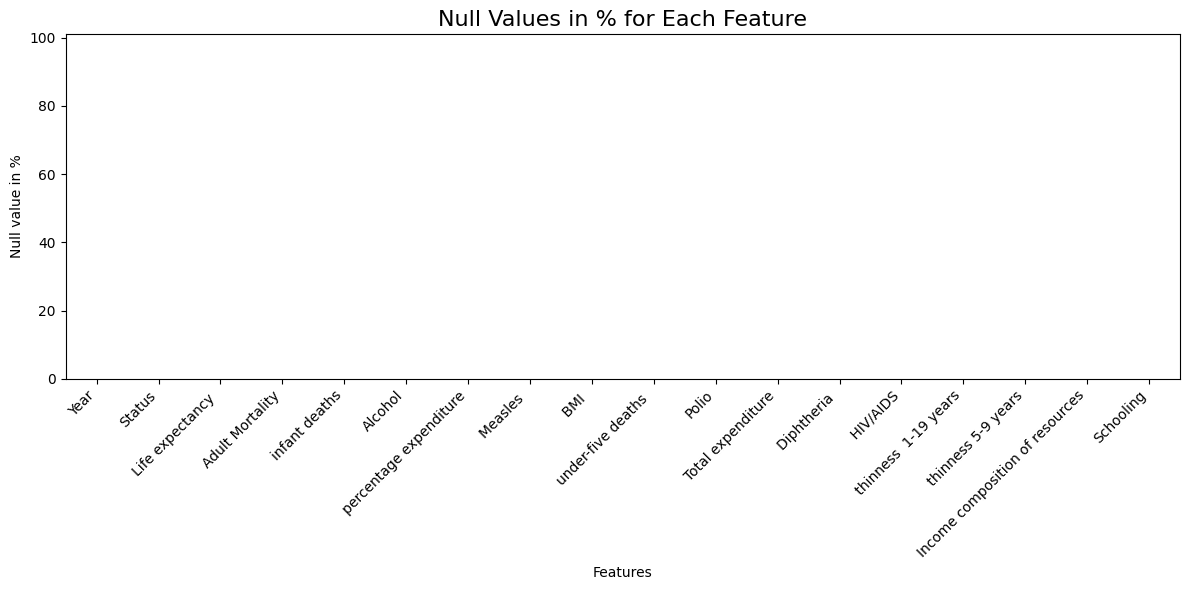

In [340]:
# Calculate the percentage of null values for each feature
null_values_count = round(imp_df.isna().sum() / imp_df.shape[0] * 100, 2).reset_index().rename(columns={'index': 'Features', 0: 'Null value in %'})

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Features', y='Null value in %', data=null_values_count, palette='viridis')

# Set the title and adjust layout
ax.set_title('Null Values in % for Each Feature', fontsize=16)
ax.set_ylim(0, 101)  # Set the y-axis range from 0 to 101

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [341]:
describe = imp_df.select_dtypes(exclude='object').describe().T
describe['skew'] = imp_df.select_dtypes(exclude='object').skew()
describe['kurtosis'] = imp_df.select_dtypes(exclude='object').kurtosis()
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Year,2928.0,2007.500000,4.610560,2000.00,2003.750000,2007.500000,2011.250000,2015.00000,0.000000,-1.209428
Life expectancy,2928.0,69.224932,9.523867,36.30,63.100000,72.100000,75.700000,89.00000,-0.638605,-0.234477
Adult Mortality,2928.0,164.796448,124.292079,1.00,74.000000,144.000000,228.000000,723.00000,1.174369,1.748860
infant deaths,2928.0,30.407445,118.114450,0.00,0.000000,3.000000,22.000000,1800.00000,9.771044,115.657480
Alcohol,2928.0,4.554744,3.983439,0.01,1.107500,3.385000,7.580000,17.87000,0.642713,-0.725276
percentage expenditure,2928.0,740.321185,1990.930605,0.00,4.853964,65.611455,442.614322,19479.91161,4.643790,26.475829
Measles,2928.0,2427.855874,11485.970937,0.00,0.000000,17.000000,362.250000,212183.00000,9.425290,114.467979
BMI,2928.0,38.201673,19.852777,1.00,19.400000,43.000000,56.100000,77.60000,-0.226679,-1.296807
under-five deaths,2928.0,42.179303,160.700547,0.00,0.000000,4.000000,28.000000,2500.00000,9.479623,109.388435
Polio,2928.0,82.603142,23.350414,3.00,78.000000,93.000000,97.000000,99.00000,-2.108867,3.831065


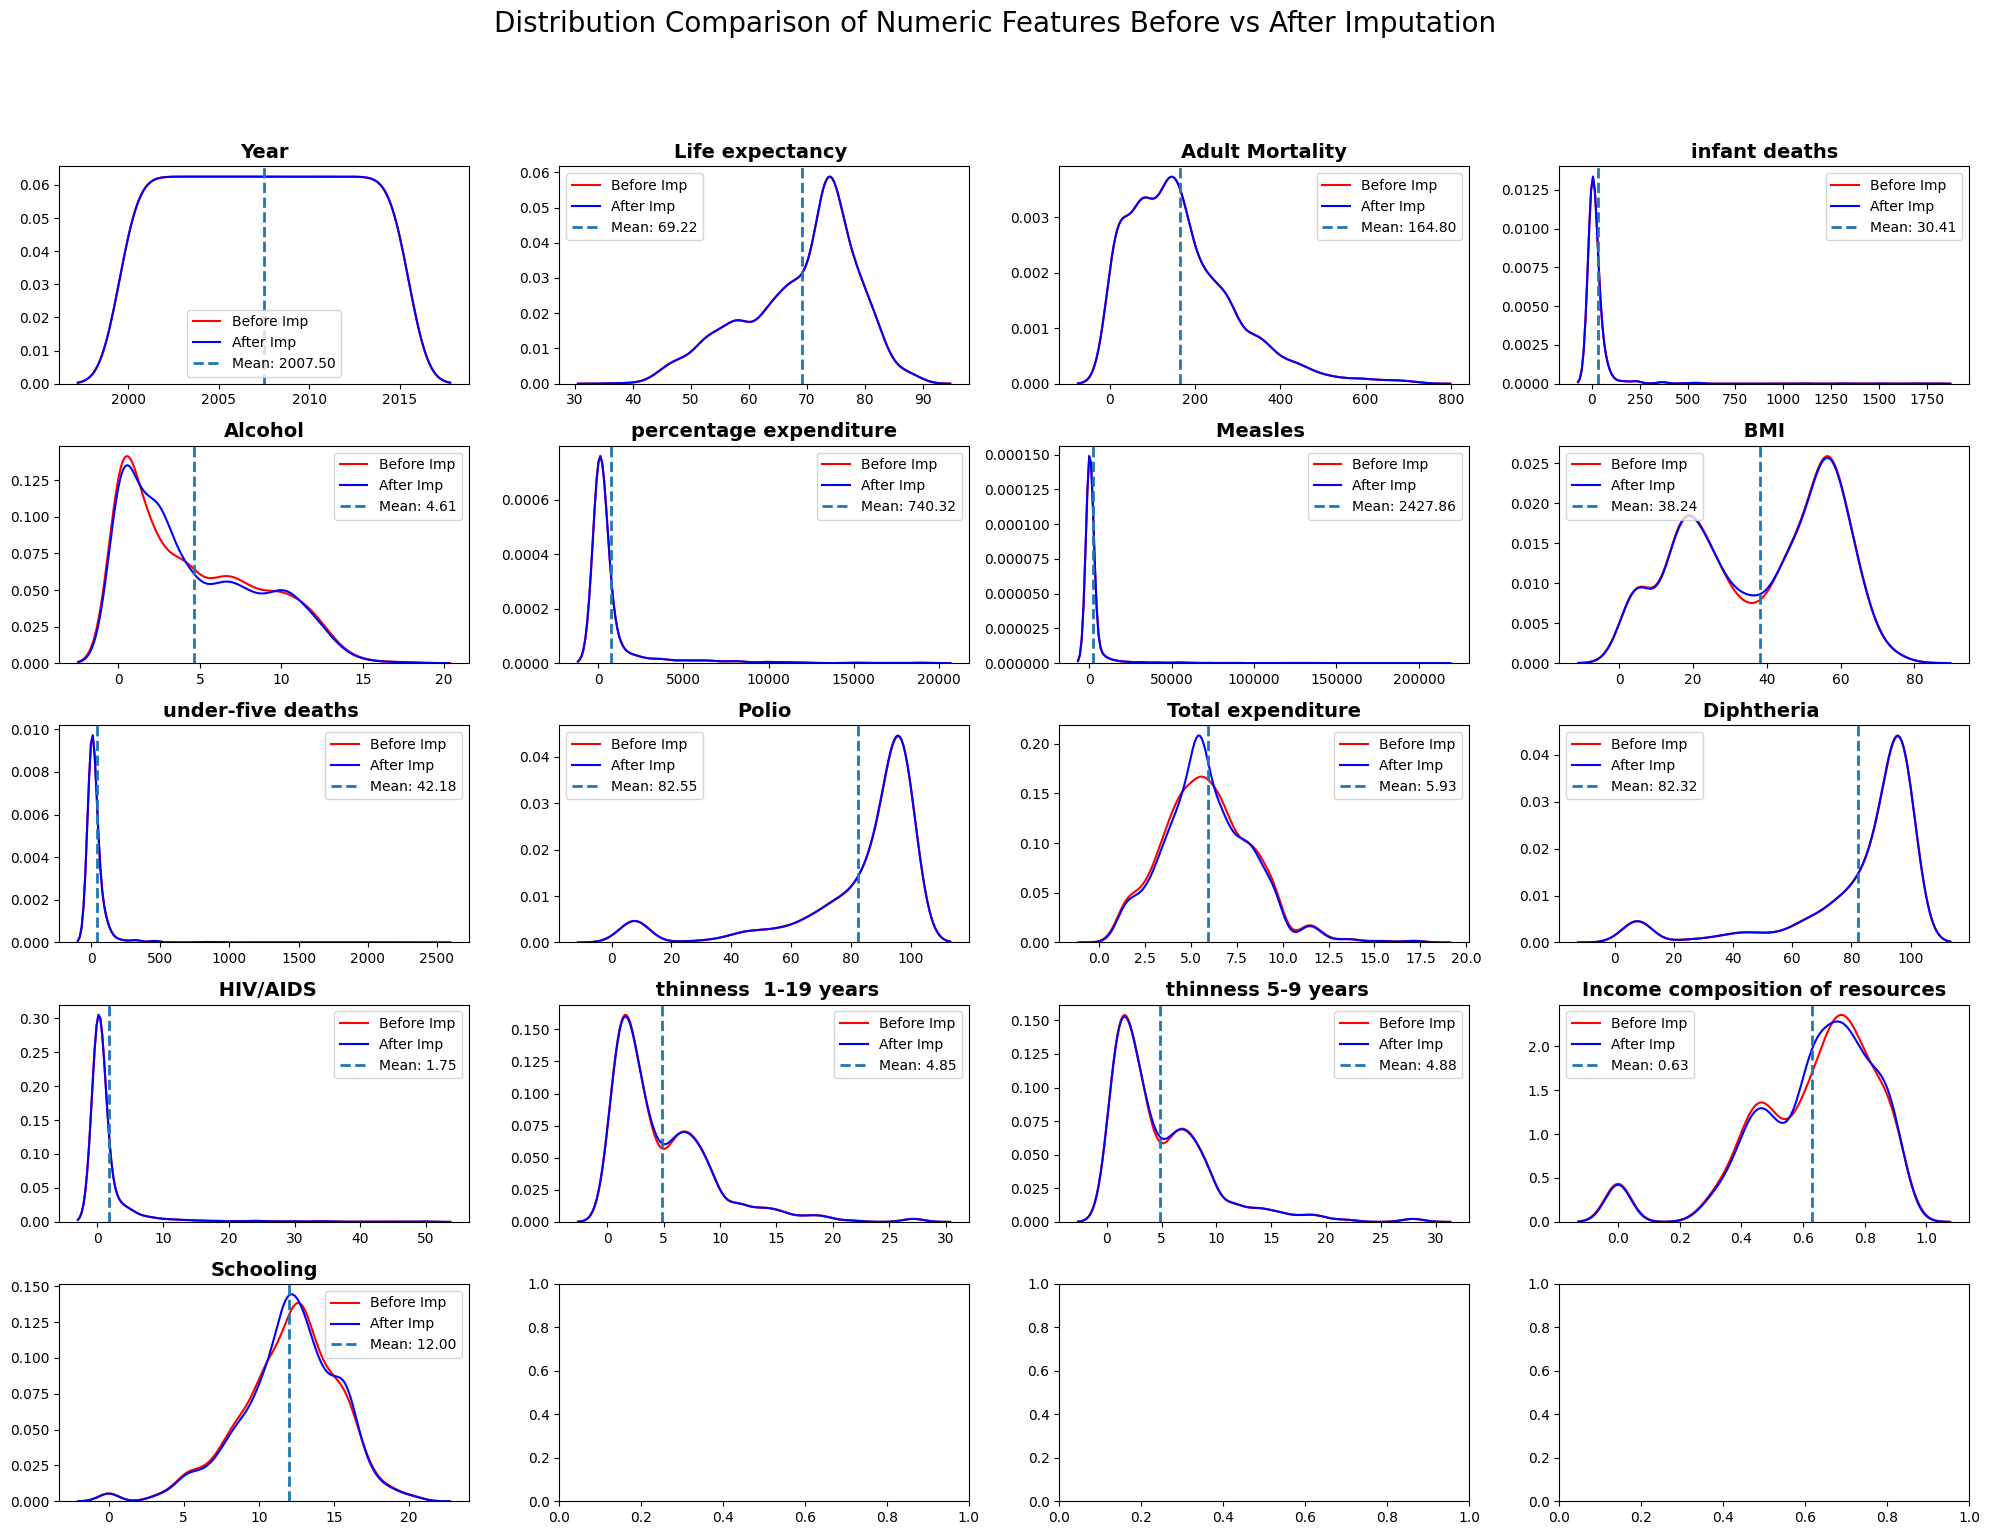

In [342]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
fig.suptitle("Distribution Comparison of Numeric Features Before vs After Imputation", fontsize=20, y=1.02)

numeric_cols = imp_df.select_dtypes(exclude=['object','bool']).columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(df[col], ax=ax, color='red', label='Before Imp')
  sns.kdeplot(imp_df[col], ax=ax , color='blue' ,label='After Imp')
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = df[col].mean()
  ax.axvline(mean_value, linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


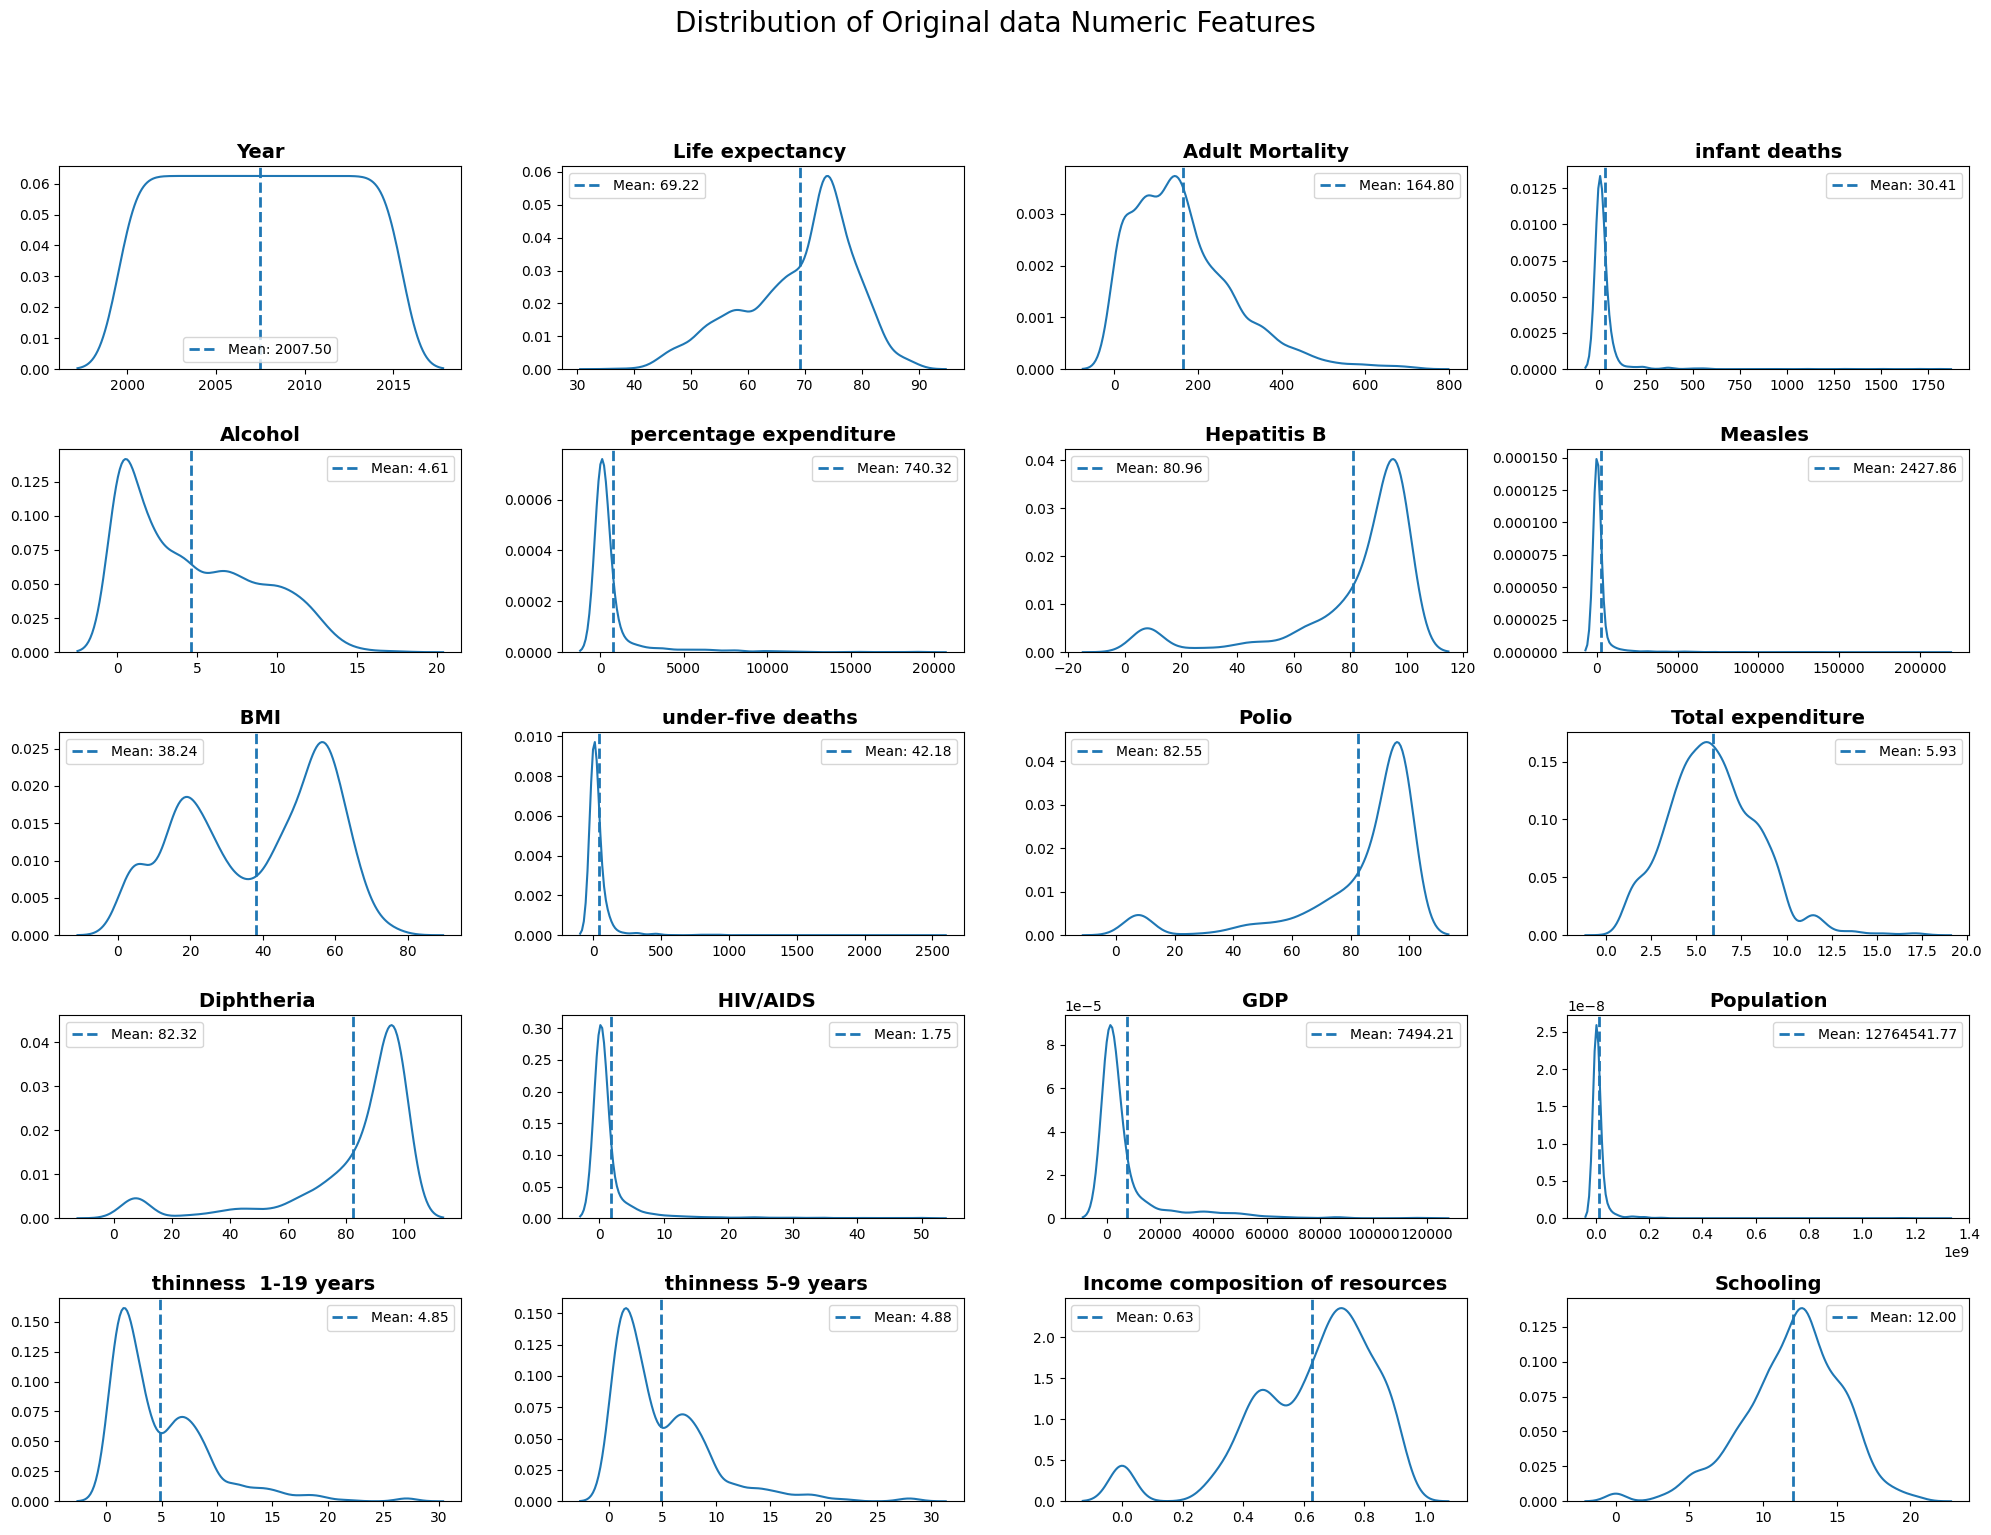

In [343]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
fig.suptitle("Distribution of Original data Numeric Features", fontsize=20, y=1.02)

numeric_cols = df.select_dtypes(exclude=['object','bool']).columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.kdeplot(df[col], ax=ax)
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = df[col].mean()
  ax.axvline(mean_value, linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


### Outliers analysis & Handling

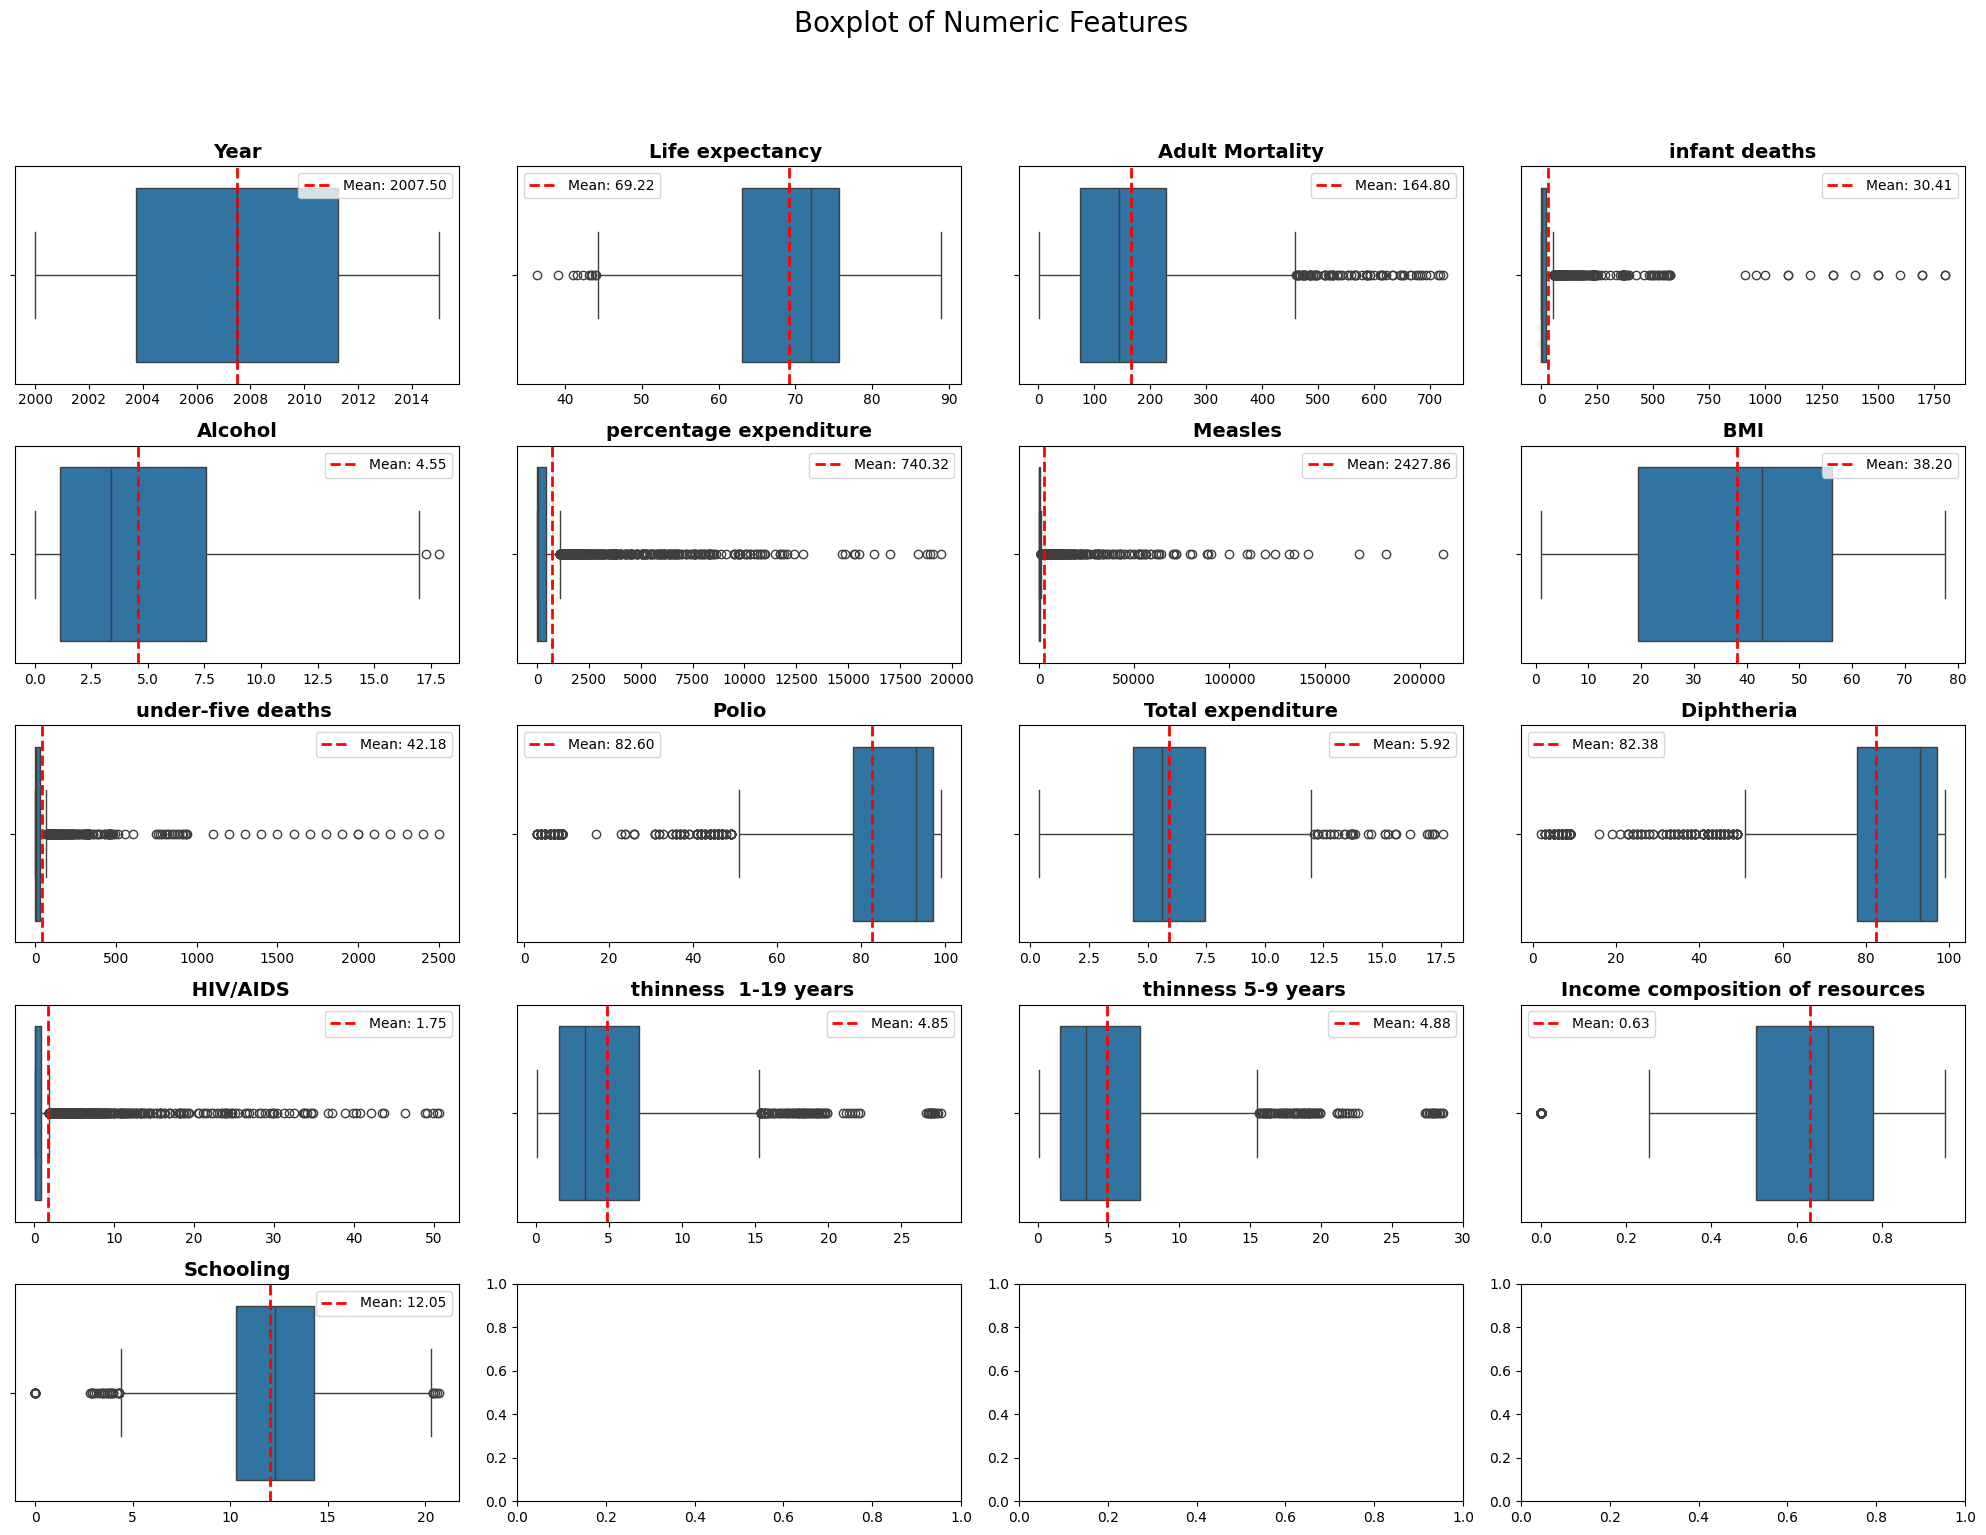

In [344]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
fig.suptitle("Boxplot of Numeric Features", fontsize=20, y=1.02)

numeric_cols = imp_df.select_dtypes(exclude=['object','bool']).columns.tolist()

for col, ax in zip(numeric_cols, axes.flatten()):
  sns.boxplot(imp_df[col], ax=ax, orient='h')
  ax.set_title(col, fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')
  mean_value = imp_df[col].mean()
  ax.axvline(mean_value, linestyle='dashed',color='red', linewidth=2, label=f'Mean: {mean_value:.2f}')
  ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()


**Robust Scaler for Handling Outliers**

The **Robust Scaler** is a feature scaling technique that is particularly effective when dealing with outliers in your data. Unlike traditional scaling methods that use the mean and standard deviation, which can be significantly affected by outliers, the Robust Scaler uses the median and the interquartile range (IQR) to scale the data. Here’s how it works:

1. **Median Centering**:
   - Subtracts the median of the feature from each data point.
   - The median is a robust measure of central tendency that is less sensitive to outliers compared to the mean.

2. **Scaling by IQR**:
   - Divides the centered data by the interquartile range (IQR), which is the range between the 25th percentile (Q1) and the 75th percentile (Q3).
   - The IQR measures the spread of the middle 50% of the data and is less influenced by extreme values compared to the standard deviation.

#### Formula
The formula for the Robust Scaler is:

$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$


By using median and IQR, the Robust Scaler minimizes the impact of outliers on the scaling process, leading to a more stable and robust transformation of the data.

#### Example Usage
In Python, you can use the `RobustScaler` from the `sklearn.preprocessing` module:

```python
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


### Categorical Data Imputation

In [345]:
imp_df = pd.get_dummies(imp_df,columns=['Status'],dtype=int,drop_first=True)

### Regression Analysis

In [346]:
X,y = imp_df.drop('Life expectancy ',axis=1),imp_df['Life expectancy ']

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [348]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2049, 17), (879, 17), (2049,), (879,))

In [349]:
scaler = RobustScaler()

columns_names = list(X_train.columns)

X_train[columns_names] = scaler.fit_transform(X_train[columns_names])
X_test[columns_names] = scaler.transform(X_test[columns_names])

In [350]:
X_train = sm.add_constant(X_train)

In [351]:
model = sm.OLS(y_train,X_train).fit()

In [352]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     550.4
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:13   Log-Likelihood:                -5745.3
No. Observations:                2049   AIC:                         1.153e+04
Df Residuals:                    2031   BIC:                         1.163e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [353]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)

In [354]:
vif

,Features,VIF
8,under-five deaths,167.97
3,infant deaths,166.14
14,thinness 5-9 years,7.61
13,thinness 1-19 years,7.46
16,Schooling,3.53
15,Income composition of resources,3.07
0,const,2.06
4,Alcohol,2.04
17,Status_Developing,2.02
11,Diphtheria,1.92


In [355]:
X_train.drop('under-five deaths ',axis=1,inplace=True)

In [356]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     551.0
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:13   Log-Likelihood:                -5795.5
No. Observations:                2049   AIC:                         1.163e+04
Df Residuals:                    2032   BIC:                         1.172e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [357]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
13,thinness 5-9 years,7.58
12,thinness 1-19 years,7.45
15,Schooling,3.52
14,Income composition of resources,3.04
0,const,2.03
16,Status_Developing,2.02
4,Alcohol,2.00
10,Diphtheria,1.89
8,Polio,1.87
7,BMI,1.74


In [358]:
X_train.drop(' thinness 5-9 years',axis=1,inplace=True)

In [359]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     587.9
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:                -5795.6
No. Observations:                2049   AIC:                         1.162e+04
Df Residuals:                    2033   BIC:                         1.171e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [360]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
14,Schooling,3.52
13,Income composition of resources,3.04
0,const,2.02
15,Status_Developing,2.02
4,Alcohol,2.00
12,thinness 1-19 years,1.94
10,Diphtheria,1.89
8,Polio,1.86
7,BMI,1.71
2,Adult Mortality,1.70


In [361]:
X_train.drop('infant deaths',axis=1,inplace=True)

In [362]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     630.2
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:                -5795.6
No. Observations:                2049   AIC:                         1.162e+04
Df Residuals:                    2034   BIC:                         1.171e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [363]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
13,Schooling,3.51
12,Income composition of resources,3.03
0,const,2.02
14,Status_Developing,2.02
3,Alcohol,1.99
9,Diphtheria,1.88
7,Polio,1.86
6,BMI,1.71
2,Adult Mortality,1.70
11,thinness 1-19 years,1.63


In [364]:
X_train.drop('Year',axis=1,inplace=True)

In [365]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     679.0
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:                -5795.7
No. Observations:                2049   AIC:                         1.162e+04
Df Residuals:                    2035   BIC:                         1.170e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [366]:
X_train.drop('Total expenditure',axis=1,inplace=True)

In [367]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     735.9
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:                -5795.7
No. Observations:                2049   AIC:                         1.162e+04
Df Residuals:                    2036   BIC:                         1.169e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [368]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
11,Schooling,3.46
10,Income composition of resources,2.94
0,const,2.01
12,Status_Developing,1.97
2,Alcohol,1.92
7,Diphtheria,1.87
6,Polio,1.86
5,BMI,1.70
1,Adult Mortality,1.68
9,thinness 1-19 years,1.62


In [369]:
X_train.drop('Alcohol',axis=1,inplace=True)

In [370]:
model = sm.OLS(y_train,X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     803.1
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:47:15   Log-Likelihood:                -5795.9
No. Observations:                2049   AIC:                         1.162e+04
Df Residuals:                    2037   BIC:                         1.168e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [371]:
vif =  pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
10,Schooling,3.31
9,Income composition of resources,2.94
0,const,1.97
6,Diphtheria,1.87
5,Polio,1.86
4,BMI,1.70
1,Adult Mortality,1.67
11,Status_Developing,1.60
8,thinness 1-19 years,1.57
7,HIV/AIDS,1.33


In [372]:
analyitical_col_to_drop = ['under-five deaths ',' thinness 5-9 years', 'infant deaths','Year','Total expenditure','Alcohol']

In [373]:
X_test.drop(columns=analyitical_col_to_drop,axis=1,inplace=True)

In [374]:
X_test = sm.add_constant(X_test)

In [375]:
# residual analysis
y_train_pred = model.predict(X_train)
train_res = y_train - y_train_pred

In [376]:
# residual analysis
y_test_pred = model.predict(X_test)
test_res = y_test - y_test_pred

**Regression Analysis Evaluation**

In [377]:
print(f'Train MSE : {mean_squared_error(y_train,y_train_pred)}, Train MAE : {mean_absolute_error(y_train,y_train_pred)}, R2 Train : {r2_score(y_train,y_train_pred)}')
print(f'Test MSE  : {mean_squared_error(y_test,y_test_pred)},    Test MAE : {mean_absolute_error(y_test,y_test_pred)},   R2 Test  : {r2_score(y_test,y_test_pred)}')

Train MSE : 16.76631887054549, Train MAE : 3.0499182026027016, R2 Train : 0.8126129938773906
Test MSE  : 17.606785271512983,    Test MAE : 3.073470020839111,   R2 Test  : 0.8114712629878529


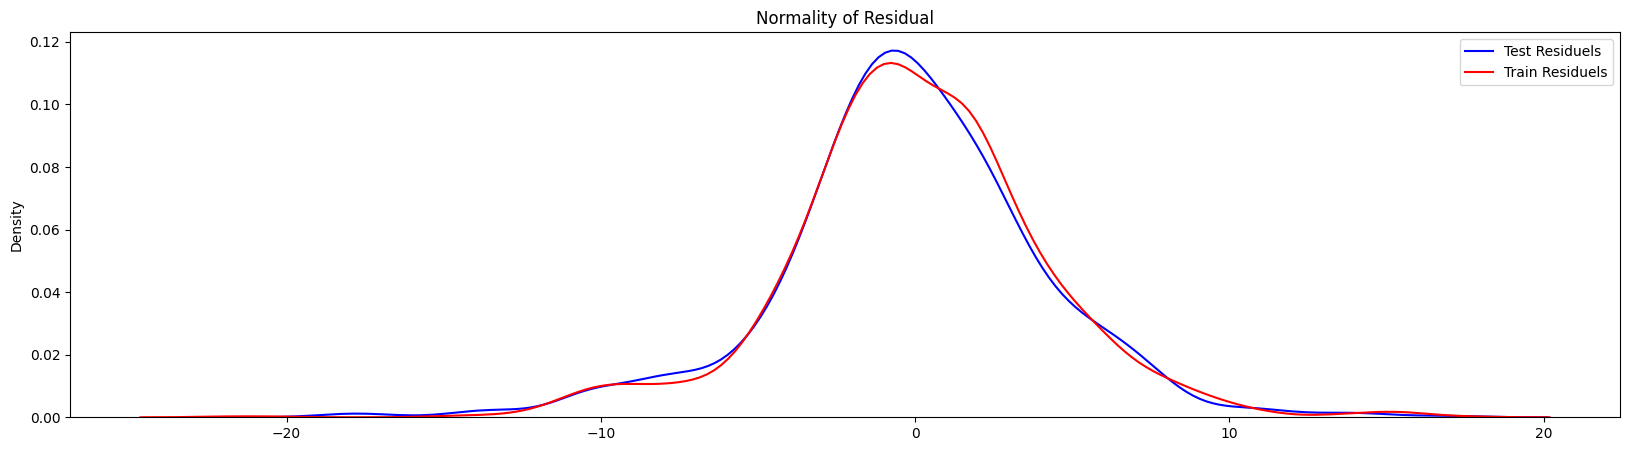

In [378]:

plt.figure(figsize=(20,5))
plt.title('Normality of Residual')
sns.kdeplot(test_res,color='blue',label='Test Residuels')
sns.kdeplot(train_res,color='red',label='Train Residuels')
plt.legend()
plt.show()

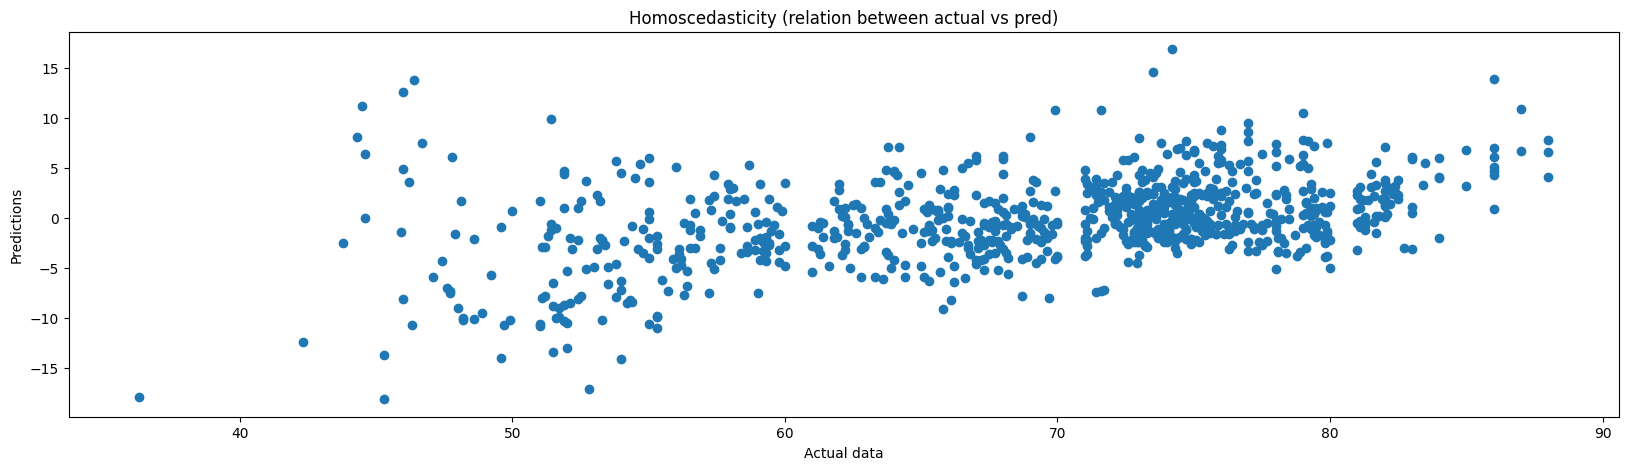

In [379]:

plt.figure(figsize=(20,5))
plt.title('Homoscedasticity (relation between actual vs pred)')
plt.scatter(y_test,test_res)
plt.xlabel('Actual data')
plt.ylabel('Predictions')
plt.show()

In [380]:
final_features = X_train.columns.to_list()[1:]

**Observation**

- We had done regression analysis where we got 11 feature as out Independent features

- `Adult Mortality`,
 `percentage expenditure`,
 `Measles `,
 ` BMI `,
 `Polio`,
 `Diphtheria `,
 ` HIV/AIDS`,
 ` thinness  1-19 years`,
 `Income composition of resources`,
 `Schooling`,
 `Status_Developing`


### Model Building & Hyper Parameter Tuning

In [381]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

In [382]:
KNR = KNeighborsRegressor()
LR = LinearRegression()
SGDR = SGDRegressor()
RFR = RandomForestRegressor()

# Import data
df = pd.read_csv('/content/Life Expectancy Data.csv').dropna(subset=['Life expectancy '])

# Drop unnecessary features
df = df.drop(columns=columns_to_drop,axis=1)

# Handling Missing Data
# Missing data less than 0.5%
values = dict(zip(Missing_data_features_less_than5,Missing_data_features_less_than5_values))
df[Missing_data_features_less_than5] = df[Missing_data_features_less_than5].fillna(value=values)

# Missing data greater than 0.5%
values = dict(zip(Missing_data_features_greater_than5, Missing_data_features_greater_than5_developed_medians))
for feature in Missing_data_features_greater_than5:
    df.loc[df['Status'] == 'Developed', feature] = df.loc[df['Status'] == 'Developed', feature].fillna(value=values[feature])

values = dict(zip(Missing_data_features_greater_than5,Missing_data_features_greater_than5_developing_medians))

for feature in Missing_data_features_greater_than5:
  df.loc[df['Status'] == 'Developing', feature] = df.loc[df['Status'] == 'Developing', feature].fillna(value=values[feature])



# Handling categorical Features
df = pd.get_dummies(df,columns=['Status'],dtype=int,drop_first=True)

# Split the data into train and test
X,y = df.drop('Life expectancy ',axis=1),df['Life expectancy ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.drop(columns=analyitical_col_to_drop,axis=1)
X_test = X_test.drop(columns=analyitical_col_to_drop,axis=1)

# Feature Transformations
scaler = RobustScaler()

columns_names = list(X_train.columns)
X_train[columns_names] = scaler.fit_transform(X_train[columns_names])
X_test[columns_names] = scaler.transform(X_test[columns_names])

# Traning base models and evaluations
for Name,model in {'KNeighborsRegressor':KNR,'LinearRegression':LR,'SGDRegressor':SGDR,'RandomForestRegressor':RFR}.items():
  print(f'---- {Name} ----')
  # Model traning
  score = cross_val_score(model, X_train,y_train,cv=10,scoring='neg_mean_absolute_error')
  model = model.fit(X_train,y_train)
  X_train_preds =  model.predict(X_train)
  X_test_preds =  model.predict(X_test)




  # model evaluation
  print(f'Train MSE : {mean_squared_error(y_train,X_train_preds)}, Train MAE : {mean_absolute_error(y_train,X_train_preds)}, R2 Train : {r2_score(y_train,X_train_preds)}')
  print(f'Test MSE : {mean_squared_error(y_test,X_test_preds)}, Test MAE : {mean_absolute_error(y_test,X_test_preds)}, R2 Test  : {r2_score(y_test,X_test_preds)}')
  print(f'Cross val Avg Score (neg_mean_absolute_error) : {score.mean()}')
  print('\n')

---- KNeighborsRegressor ----
Train MSE : 8.178864812103464, Train MAE : 1.9744948755490481, R2 Train : 0.9085897743890539
Test MSE : 14.015010238907852, Test MAE : 2.6015699658703073, R2 Test  : 0.8499310272257011
Cross val Avg Score (neg_mean_absolute_error) : -2.5676746532759447


---- LinearRegression ----
Train MSE : 16.76631887054549, Train MAE : 3.0499182026027074, R2 Train : 0.8126129938773906
Test MSE : 17.60678527151299, Test MAE : 3.073470020839111, R2 Test  : 0.8114712629878528
Cross val Avg Score (neg_mean_absolute_error) : -3.0745209153149053


---- SGDRegressor ----
Train MSE : 6.60270855550898e+23, Train MAE : 186851602938.4396, R2 Train : -7.379448035493031e+21
Test MSE : 5.1739077293924804e+23, Test MAE : 173527630606.86362, R2 Test  : -5.540081704852472e+21
Cross val Avg Score (neg_mean_absolute_error) : -199084595314.98578


---- RandomForestRegressor ----
Train MSE : 0.5538886837481704, Train MAE : 0.47241337237676895, R2 Train : 0.9938095211611954
Test MSE : 3.993

**Observation**

- `Random Forest Regressor` (Base model) have least error rate followed by `KNearestNeighbor` and `Linear Regressor`.

- We will build 2 models Random Forest for efficient performance and Linear model for accuracy and Unseen data.

In [383]:
# Final Selected Features descriptions

describe = df[final_features + ['Life expectancy ']].select_dtypes(exclude='object').describe().T
describe['skew'] = df[final_features + ['Life expectancy ']].select_dtypes(exclude='object').skew()
describe['kurtosis'] = df[final_features + ['Life expectancy ']].select_dtypes(exclude='object').kurtosis()
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Adult Mortality,2928.0,164.796448,124.292079,1.0,74.000000,144.000000,228.000000,723.00000,1.174369,1.748860
percentage expenditure,2928.0,740.321185,1990.930605,0.0,4.853964,65.611455,442.614322,19479.91161,4.643790,26.475829
Measles,2928.0,2427.855874,11485.970937,0.0,0.000000,17.000000,362.250000,212183.00000,9.425290,114.467979
BMI,2928.0,38.201673,19.852777,1.0,19.400000,43.000000,56.100000,77.60000,-0.226679,-1.296807
Polio,2928.0,82.603142,23.350414,3.0,78.000000,93.000000,97.000000,99.00000,-2.108867,3.831065
Diphtheria,2928.0,82.377732,23.639851,2.0,78.000000,93.000000,97.000000,99.00000,-2.083471,3.610550
HIV/AIDS,2928.0,1.747712,5.085542,0.1,0.100000,0.100000,0.800000,50.60000,5.386623,34.766398
thinness 1-19 years,2928.0,4.848429,4.396646,0.1,1.600000,3.400000,7.100000,27.70000,1.721479,4.046072
Income composition of resources,2928.0,0.631369,0.207245,0.0,0.504000,0.673000,0.780250,0.94800,-1.173091,1.568665
Schooling,2928.0,12.050478,3.290016,0.0,10.300000,12.300000,14.300000,20.70000,-0.601963,0.949755


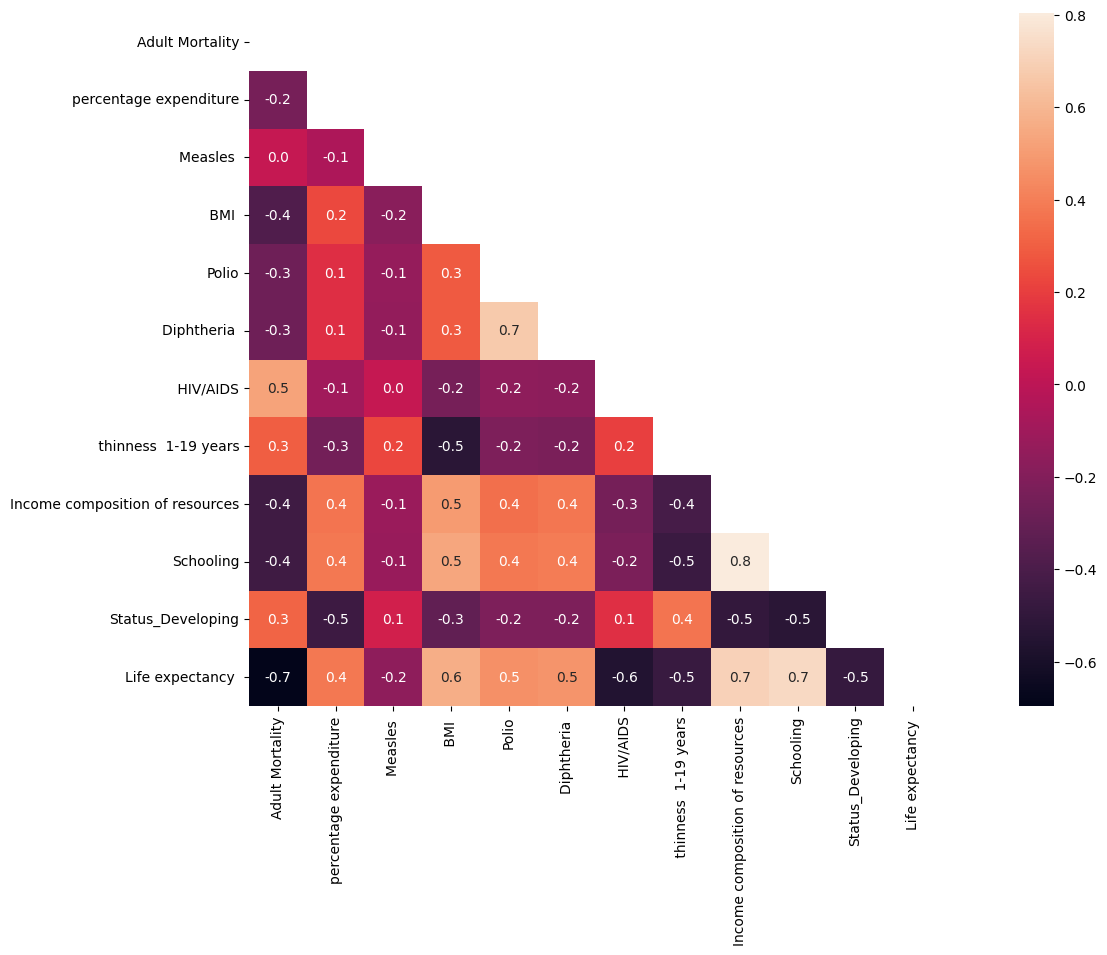

In [384]:
# Final Selected Features correlation heatmap

plt.figure(figsize=(20,9))
correlation = df[final_features + ['Life expectancy ']].select_dtypes(exclude='object').corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt = '.1f', mask=mask, square=True)
plt.show()